## Etudiant 1: GIANG Phuong-Thu, Cécile (3530405)
## Etudiant 2: LENOIR Romain (3670199)

# TME 10 : méthodes discriminantes

Le but de ce TME est de comparer les approches en modélisation maximum de vraisemblance et maximum a posteriori au niveau de la modélisation même du problème dans le cas de la classification. 

Nous notons  les observations $\mathbf x_i \in \mathbb R^d$ et les étiquettes binaires associées $y_{i} \in \mathcal Y = \{0, 1\}$.
Nous faisons l'hypothèse que les couples $(\mathbf x_i, y_{i})$ sont tirés de manière i.i.d. et suivent une loi inconnue $P(X,Y)$. 

***Résumé du max de vraisemblance:***<BR>
1. Choix d'une modélisation $\Theta$ pour les $\mathbf x_i$ (par exemple une gaussienne multivariée ou une modélisation dimension par dimension selon une loi choisie en accord avec les experts du domaine).
1. Formalisation de la vraisemblance pour un échantillon:
$p(\mathbf x_i | \Theta)$
1. Pour chaque classe $y$ (0 ou 1 dans le cas présent), optimisation de 
    $$\Theta_y^\star = \arg \max_{\Theta} \prod_{i \in y} p(\mathbf x_i | \Theta)$$
1. Critère de décision pour un nouvel échantillon $\mathbf x_n$:
    $$\hat y_n = \arg \max_c p(\mathbf x_n | \Theta_y) $$

La méthode est simple et efficace mais ne compare jamais les échantillons des différentes classes pour prendre une décision.

***Idée des approches discriminantes:***<BR>
1. Choix d'un modèle pour $p(y_i | \mathbf x_i)$. Le modèle le plus connu est la régression logistique qui, comme le nom ne l'indique pas est un modèle de classification. C'est ce modèle que nous allons étudier:
    $$p(y_i=1 | \mathbf x_i) = \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))},\qquad \mbox{Paramètres : } \mathbf w, b $$
1. Dans le cas à deux classes uniquement; après avoir remarqué que nous avons choisi un codage des classes de type Bernoulli... Utilisation de l'astuce de Bernoulli pour calculer la vraisemblance d'un échantillon:
$$ p(y_i | \mathbf x_i) = \left( \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{y_i} \left(1- \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{1-y_i} $$
1. Max de vraisemblance sur ***sur l'ensemble des données***:
    $$\mathbf w^\star, b^\star = \arg \max_{\mathbf w, b} \prod_{i} p(\mathbf x_i, y_i | \mathbf w, b) = \arg \max_{\mathbf w, b} \prod_{i} p( y_i|\mathbf x_i, \mathbf w, b) p(\mathbf x_i| \mathbf w, b)$$
En faisant l'hypothèse que les $\mathbf x_i$ sont équiprobables (pas de poids sur les observations):
$$\mathbf w^\star, b^\star = \arg \max_{\mathbf w, b} \prod_{i} p( y_i|\mathbf x_i, \mathbf w, b)$$


## Chargement des librairies et des données USPS

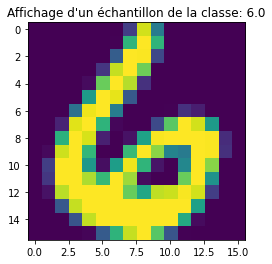

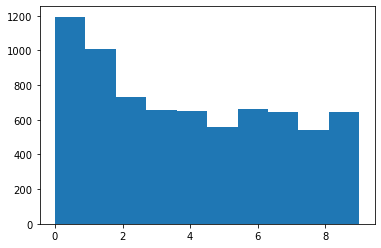

In [324]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def load(filename):
    f=open(filename,'r')
    s = f.readline() # virer la premiere ligne
    X = np.array([[float(d) for d in lig.split()] for lig in f if len(lig)>10])
    Y = X[:,0] # premiere colonne
    X = X[:,1:]
    f.close()
    return X,Y

X,Y = load('data/usps_train.txt')
Xt,Yt = load('data/usps_test.txt')

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(X[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

# étude très rapide des données:
plt.figure()
plt.hist(Y, 10) # histogramme de répartition des 10 classes
plt.show()

## Exercice 1: retour sur le max de vraisemblance

Nous retravaillons rapidement le max de vraisemblance pour obtenir un baseline. Nous allons travailler en bayesien naif sur des images binarisées:
$$ x_{ij} \in \{0,1\}, \qquad p(x_i | \Theta) = \prod_j p(x_{ij} | \Theta_j)$$

Le code est fourni, il suffit de l'exécuter:

**Notes personnelles:**

Pour une certaine classe $k \in \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9 \}$ d'images, $\theta_k$ est le vecteur des $d$ valeurs moyennes pour chaque pixel d'une image de classe $k$, avec $d$ le nombre d'attributs d'un échantillon $x_i$. Ici, $d = 256$.

In [228]:
# -- Apprentissage d'un modèle de Bernoulli naif par classe

def learnBernoulli (X,Y):
    theta = [(X[Y==y].mean(0)) for y in np.unique(Y)]
    return np.array(theta)

# -- Evaluation de la vraisemblance d'une base d'échantillon

def logpobsBernoulli(X, theta):
    """ Retourne une matrice avec les vraisemblances des échantillons pour toutes les classes.
        @param X: float array x array, matrice d'images
        @param theta: float array x array, matrice des theta_k
    """
    seuil = 1e-4
    theta = np.maximum(np.minimum(1-seuil, theta),seuil)
    logp = [[ (x*np.log(mod)+(1-x)*np.log(1-mod)).sum() for x in X] for mod in theta ]
    return np.array(logp)

Bernoulli : Taux bonne classification en apprentissage :  0.8723083253326018
Bernoulli : Taux bonne classification en test :  0.8236173393124065


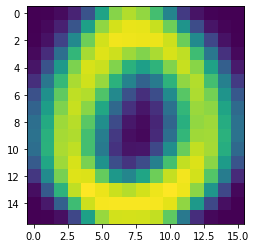

In [229]:
# binariser X (sinon la modélisation Bernoulli ne tient plus)
Xb = np.where(X >0, 1., 0.)
Xbt = np.where(Xt >0, 1., 0.)


## Max de Vraisemblance
theta = learnBernoulli ( Xb,Y )

## Evaluation de la vraisemblance des échantillons
logp  = logpobsBernoulli(Xb, theta)
logpT = logpobsBernoulli(Xbt, theta)

# calcul des y de prédiction à partir de la matrice des vraisemblances
ypred_b  = logp.argmax(0)
ypredT_b = logpT.argmax(0)

print("Bernoulli : Taux bonne classification en apprentissage : ",np.where(ypred_b != Y, 0.,1.).mean())
print("Bernoulli : Taux bonne classification en test : ",np.where(ypredT_b != Yt, 0.,1.).mean())

# resultats qualitatifs: affichage des poids du modèle de la classe 0
plt.figure()
plt.imshow(theta[0].reshape(16,16))
plt.show()

## Exercice 2: prise en compte des informations a priori et passage au MAP

La seule information dont nous disposons est la répartition des classes (cf histogramme).
1. Calcul des probabilités a priori des classes 
1. Evaluation des performances avec prise en compte de ces informations a priori
1. Afficher les images des chiffres qui changent de classe avec les prédictions avant/après

Cet exercice correspondant principalement à des compétences de séances précédentes, le code est fourni.

Bernoulli : Taux bonne classification MAP en apprentissage :  0.8720340145384721
Bernoulli : Taux bonne classification MAP en test :  0.8236173393124065


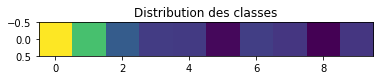

<Figure size 432x288 with 0 Axes>

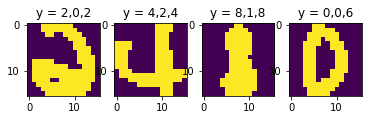

In [230]:
# CORRECTION
pAPriori = np.array([np.where(Y==i, 1, 0).sum() for i in np.unique(Y)]).reshape(10,1) / len(Y)

plt.figure()
plt.imshow(pAPriori.T, interpolation=None)
plt.title('Distribution des classes')

# pas de modification sur les paramètres optimaux
ypred  = (logp + np.log(pAPriori)).argmax(0) # utilise le dispatch numpy
ypredT = (logpT+ np.log(pAPriori)).argmax(0)

print ("Bernoulli : Taux bonne classification MAP en apprentissage : ",np.where(ypred != Y, 0.,1.).mean())
print ("Bernoulli : Taux bonne classification MAP en test : ",np.where(ypredT != Yt, 0.,1.).mean())

# recherche d'un point ayant changé de classe avec le MAP:
index = np.where(ypred != ypred_b)[0]
plt.figure()
plt.subplots(1,len(index))
for num,i in enumerate(index):
    plt.subplot(1,len(index),num+1) # subplot commence à 1 (héritage matlab)
    plt.imshow(Xb[i].reshape(16,16))
    plt.title("y = "+str(int(Y[i])) + ","+str(ypred[i])+","+str(ypred_b[i]) )
plt.show()

## Exercice 3: codage de la régression logistique

***Rappel: régression logistique = système de classification***

$$ p(y_i | \mathbf x_i) = \left( \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{y_i} \left(1- \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{1-y_i} $$


Soit en agrégeant sur la base de données et notant: $exp = \exp( -(  \mathbf x_i  \mathbf w + b))$
$$\mathcal L_{log} = \sum_i  y_i \log(\frac{1}{1+exp}) + (1-y_i) \log(1-\frac{1}{1+exp})$$ 
$$\mathcal L_{\log}=\sum_{i=1}^N \log(1+exp) ( -y_i -1 + y_i) + \log(exp)(1-y_i)$$

Soit:
$$ \frac{\partial  }{\partial w_j} L_{\log} =\sum_{i=1}^N x_{ij}( y_i-\frac{1}{1+exp}) \in \mathbb R$$
On remarque qu'il est possible de passer à une écriture vectorielle:
$$ \nabla_{\mathbf w} L_{\log} =X^T ( Y-\frac{1}{1+\exp( -(  \mathbf X  \mathbf w + b))}) \in \mathbb R^d$$
$$ \frac{\partial  }{\partial b} L_{\log} =\sum_{i=1}^N ( y_i-\frac{1}{1+exp}) \in \mathbb R$$

Note: il est possible de manière **facultative**, comme dans le TME de la semaine dernière, de construire:
$$Xe = \left[\begin{array}{cc}
                \mathbf x_0 & 1\\
                \vdots & \vdots\\
                \mathbf x_N & 1
                \end{array}
                \right] $$
On supprime alors les $b$ pour obtenir:
$$ \nabla_{\mathbf w_e} L_{\log} =X_e^T ( Y-\frac{1}{1+\exp( -(  \mathbf X_e  \mathbf w_e))}) \in \mathbb R^{d+1}$$

### Liste des questions
1. Coder la descente de gradient classique (batch) entre deux classes <BR>
    Attention, il s'agit d'une montée de gradient pour maximiser la vraisemblance <BR>
    Proposition de critère d'arrêt: $\max_j(|w_{new,j} - w_{old,j}| ) < 10^{-3}$
1. Evaluer les performances sur la distinction entre les 2 et les 3
1. Passer au multi-classe avec le paradigme un-contre-tous
1. [OPT, à faire à la fin] passer à un algorithme de gradient stochastique

**1ère version de la montée de gradient (calcul itératif)**

In [245]:
# ----------------- 1- MONTEE DE GRADIENT -----------------

def rl_gradient_batch(X,Y, epsilon = 1e-3, niter_max=1000):
    """ Code de la descente de gradient (batch) entre deux classes.
        @param X: float array x array, liste d'images
        @param Y: float array, liste des classes correspondant à chaque image de X
        @param epsilon: float, taux d'apprentissage pour la descente de gradient
        @param niter_max: int, nombre maximum d'itérations (arrêt si on n'a pas atteint la convergence avant)
        @return w: float array, 1er paramètre de la montée de gradient
        @return b: float, 2ème paramètre de la montée de gradient
    """
    N,d = X.shape
    
    # ------- ETAPE 1: Initialisation de w et b
    
    w = np.zeros(d, dtype=float)
    b = np.zeros(d, dtype=float)
    
    # ------- ETAPE 2: Bouclage tant que convergence non-atteinte
    
    iter = 0    
    
    while iter < niter_max:
        
        # Calcul des dérivées partielles de L_log en wj (dL_wj) et en b (dL_b)
        
        dL_w = np.array([np.sum([X[i][j] * (Y[i] - (1/(1+np.exp(-(X[i]*w + b))))) for i in range(N)]) for j in range(d)])
        dL_b = np.sum([Y[i] - (1/(1+np.exp(-(X[i]*w + b)))) for i in range(N)])
    
        # --- MAJ ?
        w_new = w + epsilon * dL_w
        b_new = b + epsilon * dL_b
        
        if np.max(np.abs(w_new-w)) < 10e-3:
            print('Convergence atteinte en', iter, 'itérations.')
            break
        else:
            w = w_new
            b = b_new
            iter += 1
    
    return w,b # ou seulement w si vous avez ajouté les 1 dans X

**Remarques:**

Lorsque nous faisons tourcer ce code, il est bien trop long. Nous décidons donc de procéder avec la matrice d'enrichiessement, comme dans le TME 9, qui nous rend un $\omega$ optimal en un temps court.

**2ème version de la montée de gradient (avec matrice enrichie $X_e$)**

In [276]:
# ------- Fonction qui renvoie une la matrice enrichie Xe à partie du vecteur X -------

def make_mat_lin_biais(X):
    """ Fonction d'enrichissement: permet de construire la matrice enrichie Xe à partir
        du vecteur X, pour le problème y = ax + b + eps.
        @param X: float array, vecteur unidimensionnel
        @return Xe: float array x array, matrice enrichie de X
    """
    N = len(X)
    return np.hstack((X,np.ones((N,1))))

In [277]:
# --- Pour travailler en matrice: (Re)-construction de la matrice contenant les X et un biais

Xe = make_mat_lin_biais(X_23) # dataset linéaire, transformation lineaire des données

def rl_gradient_batch(X, Y, epsilon=1e-3, niter_max=1000):
    """ Fonction de montée de gradient permettant de trouver le paramètre w optimal,
        ie le w qui minimise la fonction de coût. Retourne le w optimal ainsi que la liste des
        nIterations w calculés
        @param X: float array, ensemble des échantillons
        @param Y: float array, classes associées à chaque échantillon de X
        @param epsilon: float, erreur/bruit/résidu
        @param niter_max: int, nombre d'itérations sur w
        @return w: float array, w optimal
    """
    N,d = X.shape

    # --- ETAPE 0: Initialisation de w à 0
    w = np.zeros(d, dtype=float)
    
    # --- ETAPE 1: Boucle sur w
    iter = 0
    while iter < niter_max:
        Xw = np.dot(X, w)
        w_new = w + epsilon * np.dot(X.T, Y - 1/(1 + np.exp(-Xw))) # Calcul du gradient
        
        if np.max(np.abs(w_new-w)) < 10e-3:
            print('Convergence atteinte en', iter, 'itérations.')
            break
        else:
            w = w_new
            iter += 1
    
    return w # la dernière valeur (meilleure)

**Test de la classification par régression logistique avec les classes d'images 2 et 3:**

In [295]:
# ------- 2. CAS SUR LES CLASSES 2 ET 3, PASSAGE A UN CODAGE EN {0, 1} POUR Y -------

cl1 = 2
cl2 = 3

# Données d'apprentissage
X_23 = X[(Y==cl1)|(Y==cl2),:]
Y_23 = np.where(Y[(Y==cl1)|(Y==cl2)] == cl1, 1., 0.)

# Données de test
Xt_23 = Xt[(Yt==cl1)|(Yt==cl2),:]
Yt_23 = np.where(Yt[(Yt==cl1)|(Yt==cl2)] == cl1, 1., 0.)

print("Taille des données :",X_23.shape,Y_23.shape)

# application de la montée de gradient & evaluation des performances
# attention à afficher les Ypred et les Y_23 pour vérifier qu'ils sont comparables

# --- Apprentissage du paramètre w* à partir des données d'apprentissage X_23 et Y_23

w = rl_gradient_batch(X_23, Y_23, epsilon = 1e-3, niter_max=1000)
print('\nw = ', w)

Taille des données : (1389, 256) (1389,)
Convergence atteinte en 39 itérations.

w =  [ 1.95082027e-02  4.11306972e-02  5.66261335e-02  8.35390375e-02
  8.21855818e-02  2.00200859e-01  3.26134061e-01  3.50469593e-01
 -1.90652904e-02 -4.81976327e-01 -4.61864422e-01 -3.24390524e-01
 -1.52392674e-01 -2.56362044e-02  2.96311459e-03 -8.27821725e-06
  4.71170377e-02  1.74666393e-01  2.35926241e-01  2.07129409e-01
  2.76072900e-01  2.37206953e-01  1.77188948e-01  5.24965711e-02
 -6.05815626e-02 -3.54306235e-01 -6.83620911e-01 -6.11600130e-01
 -3.47201643e-01 -1.44986236e-01  7.41116822e-03 -3.85486379e-03
  5.85872696e-02  2.00190663e-01  2.57270651e-01  4.47052275e-01
  4.56261849e-01  1.87161600e-01 -1.40317468e-01 -2.49878673e-01
 -9.41827315e-02 -3.62346569e-02 -4.30715404e-01 -6.24666907e-01
 -5.91590924e-01 -3.02132271e-01 -7.04255280e-02 -1.66889252e-02
  6.83856103e-02  2.31202041e-01  4.64060835e-01  6.73935612e-01
  5.46636784e-01  2.12569758e-01  3.70746955e-02  3.77210882e-02
  2.

**Prédiction des classes pour les données d'apprentissage et les données de test:**

In [304]:
# On choisit la classe pour laquelle la proba p(yi|xi) est maximale pour tout échantillon xi de Xt_23

def P_YsachantX(xi, yi, w):
    """ Calcul de p(yi|xi).
    """
    return (1 / (1 + np.exp(-xi*w) ) )**yi * (1- (1 / (1 + np.exp(-xi*w) ) ) )**(1-yi)



def taux_BC(X, Y, w):
    """ Renvoie le taux de bonne classification sur les données X et Y, pour un certain paramètre w
    """
    # Initialisation et calcul de la liste des classes prédites à partir du paramètre w* précédemment calculé:
    
    Ypred = []
    for i in range(len(X)):
        Ypred.append( np.argmax([np.sum(P_YsachantX(X[i], 0, w)), np.sum(P_YsachantX(X[i], 1, w))]) )
    
    # Calcul du taux de bonne classification:
    # bc vaut 1 à l'indice i si la classe prédite pour X[i] vaut bien Y[i]
    bc = [ int(Y[i] == Ypred[i]) for i in range(len(Y))]
    taux_bc = np.sum(bc)/len(bc)
    
    return Ypred, taux_bc

**Calcul des taux de bonne classification pour les données d'apprentissage et de test:**

On peut décommenter les lignes ci-dessous pour afficher les classes prédites et les classes attendues.

In [317]:
# Taux de bonne classification pour les données d'apprentissage
Y_pred_train, taux_bc_train = taux_BC(X_23, Y_23, w)

#print('\t\t\t----------------- Sur les données d\'apprentissage: -----------------\n')
#print('Classes attendues: \n', np.ndarray.tolist(Y_23))
#print('\n\nClasses prédites: \n', Y_pred_train)

# Taux de bonne classification pour les données de test
Y_pred_test, taux_bc_test = taux_BC(Xt_23, Yt_23, w)

#print('\t\t\t----------------- Sur les données d\'apprentissage: -----------------\n')
#print('Classes attendues: \n', np.ndarray.tolist(Y_23))
#print('\n\nClasses prédites: \n', Y_pred_train)

print('Taux de bonne classification en apprentissage: ', taux_bc_train)
print('Taux de bonne classification en test: ', taux_bc_test)

Taux de bonne classification en apprentissage:  0.9820014398848093
Taux de bonne classification en test:  0.9505494505494505


Sortie attendue
```
Taille des données : (1389, 256) (1389,)
convergence atteinte en  330  itérations # si vous avez fait un print dans le critère d'arret
[0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.] 
 [0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
App :  0.9992800575953924
Test :  0.9615384615384616
```

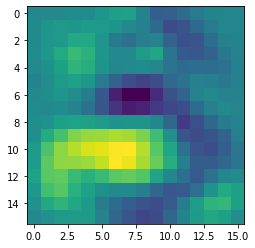

In [318]:
plt.figure()
plt.imshow(w.reshape(16,16))
plt.savefig("w23.png")
# montrer les paramètres des modèles génératifs des classes 2 et 3 pour comparer

### Passage au multiclasse

Nous allons utiliser le paradigme *un-contre-tous* mais nous allons le coder proprement dans une fonction.
Dans la fonction ```rl_multi(X,Y, epsilon = 1e-3, niter_max=1000)``` effectuer les opérations suivantes:

1. Extraire toutes les classes de Y
1. Pour chaque classe
11. Construire Ycl telle que:
$$Y_{cl} = \left\{ 
\begin{array}{cl}
1 & \mbox{ si } Y == cl     \\
0 & \mbox{ sinon (pour toutes les autres classes) }
\end{array}
\right.$$
11. Lancer un apprentissage
1. Empiler tous les $\mathbf w$ & $b$ comme suit:

$$W = \left[\begin{array}{cccc}
                \\
                \mathbf w_{cl=0} & \mathbf w_{cl=1} & \ldots & \mathbf w_{cl=9}
                \\ \\
                \end{array}
                \right] $$
$$\mathbf b = \left[\begin{array}{cccc}
                \mathbf b_{cl=0} & \mathbf b_{cl=1} & \ldots & \mathbf b_{cl=9}
                \end{array}
                \right] $$
                
On peut alors montrer que:
$$ \frac{1}{1+\exp( - \mathbf X W - \mathbf b)}  = \left[\begin{array}{cccc}
                p(Y = 1 | X = \mathbf x_1) & p(Y = 2 | X = \mathbf x_1) & \ldots & p(Y = 9 | X = \mathbf x_1)
                \\ 
                \vdots & &\ddots & \vdots\\
p(Y = 1 | X = \mathbf x_N) & p(Y = 2 | X = \mathbf x_N) & \ldots & p(Y = 9 | X = \mathbf x_N)
\\
                \end{array}
                \right] \in \mathbb R^{N\times C}$$
               Avec $N$ points et $C$ classes
1. Utiliser un ```argmax``` pour extraire le numéro de classe

In [411]:
def rl_multi(X,Y, epsilon = 1e-3, niter_max=1000):
    """ Fonction de montée de gradient permettant de trouver le paramètre w optimal pour le problème multiclasse,
        ie le w qui minimise la fonction de coût. Retourne le w optimal ainsi que la liste des
        nIterations w calculés
        @param X: float array, ensemble des échantillons (données en entrée)
        @param y: float array, classes associées à chaque échantillon de X
        @param epsilon: float, erreur/bruit/résidu
        @param niter_max: int, nombre d'itérations sur w
        @return w: float array, w optimal
    """
    
    N,d = X.shape
    
    # --- ETAPE 1: Extraction de toutes les classes de Y, initialisation de W
    classes = np.unique(Y)
    W = []
    
    # --- ETAPE 2: Initialiser les poids & lancer un modèle par classe
    # dans la boucle for, vous pouvez utiliser : Y_tmp = np.where(Y == c, 1., 0.)
    
    for c in classes: # Pour chaque classe c
        
        # Données d'apprentissage
        Y_c = np.where(Y == c, 1., 0.)
        
        W.append(rl_gradient_batch(X, Y_c, epsilon = 1e-3, niter_max=1000))
    
    # On redimensionne W pour obtenir l'empilement de W voulu:
    d = W[0].shape[0]
    W_star = W[0].reshape(d,1)
    for i in range(1,len(W)):
        W_star = np.hstack((W_star, W[i].reshape(d,1)))
    
    return W_star

In [412]:
# duree execution = 30 secondes
# n'hésitez pas à mettre un niter_max à 10 durant la phase de debug pour gagner du temps !
W = rl_multi(X,Y)

Convergence atteinte en 277 itérations.
Convergence atteinte en 94 itérations.


<ipython-input-277-57809e209613>:25: RuntimeWarning: overflow encountered in exp
  w_new = w + epsilon * np.dot(X.T, Y - 1/(1 + np.exp(-Xw))) # Calcul du gradient


Convergence atteinte en 378 itérations.
Convergence atteinte en 365 itérations.
Convergence atteinte en 119 itérations.
Convergence atteinte en 132 itérations.
Convergence atteinte en 159 itérations.


Rappels:
$$ \frac{1}{1+\exp( - \mathbf X W - \mathbf b)}  = \left[\begin{array}{cccc}
                p(Y = 1 | X = \mathbf x_1) & p(Y = 2 | X = \mathbf x_1) & \ldots & p(Y = 9 | X = \mathbf x_1)
                \\ 
                \vdots & &\ddots & \vdots\\
p(Y = 1 | X = \mathbf x_N) & p(Y = 2 | X = \mathbf x_N) & \ldots & p(Y = 9 | X = \mathbf x_N)
\\
                \end{array}
                \right] \in \mathbb R^{N\times C}$$
               Avec $N$ points et $C$ classes

In [413]:
# perf:
Y_pred  = np.argmax(1/(1+np.exp(-X@W)),1)
Yt_pred = np.argmax(1/(1+np.exp(-Xt@W)),1)
# print(Yt[:20],"\n",Yt_pred[:20])
    
pc_good   = np.where(Y_pred == Y , 1., 0.).mean()
pc_good_t = np.where(Yt_pred==Yt , 1., 0.).mean()

print("App : ",pc_good)
print("Test : ",pc_good_t)

App :  0.9499382800713209
Test :  0.8868958644743398


**Observations:**

Nous obtenons de meilleurs taux de classification que ce qui était attendu (?)
Note: Nous avons enlevé les $b$ car nous avons procédé avec une matrice d'enrichissement $X_e$.

Performances attendues:
```
App :  0.8824578247154026
Test :  0.8166417538614849
```
Pour l'instant, on ne voit pas encore l'intérêt... Mais ça va venir!

## Exercice 4: Analyse de l'évolution de la vraisemblance 

Afin de vérifier le bon fonctionnement de l'algorithme, nous proposons de calculer la vraisemblance au cours des itérations (par exemple, toutes les 10 itérations) et de retourner le résultat pour voir comment se déroule l'apprentissage et pouvoir éventuellement ajuster la valeur de $\epsilon$.

En repartant de:
$$\mathcal L_{log} = \sum_i  y_i \log(\frac{1}{1+exp}) + (1-y_i) \log(1-\frac{1}{1+exp})$$ 
Avec : $exp = \exp( -(  \mathbf x_i  \mathbf w + b))$

Modifier la fonction de calcul de la vraisemblance pour retourner l'évolution de la vraisemblance

In [419]:
def rl_gradient_batch_L(X,Y, epsilon = 1e-3, niter_max=1000):
    """ Fonction de montée de gradient permettant de trouver le paramètre w optimal,
        ie le w qui minimise la fonction de coût. Retourne le w optimal ainsi que la liste des
        nIterations w calculés
        @param X: float array, ensemble des échantillons
        @param Y: float array, classes associées à chaque échantillon de X
        @param epsilon: float, erreur/bruit/résidu
        @param niter_max: int, nombre d'itérations sur w
        @return w: float array, w optimal
        @return L: float array, liste des log-vraisemblances calculées toutes les 10 itérations
    """
    N,d = X.shape
    L = [] # init vraisemblance

    # --- ETAPE 0: Initialisation de w à 0
    w = np.zeros(d, dtype=float)
    
    # --- ETAPE 1: Boucle sur w
    iter = 0
    while iter < niter_max:
        Xw = np.dot(X, w)
        w_new = w + epsilon * np.dot(X.T, Y - 1/(1 + np.exp(-Xw))) # Calcul du gradient
        
        if np.max(np.abs(w_new-w)) < 10e-3:
            print('Convergence atteinte en', iter, 'itérations.')
            break
        else:
            w = w_new
            
            # MAJ de la liste L des vraisemblances toutes les 3 itérations
            if iter%1 == 0:
                exp = np.exp(-X[i]*w)
                L.append(np.sum([ Y[i] * np.log(1/(1 + exp)) + (1 - Y[i]) * np.log(1 - 1/(1 + exp)) for i in range(N)]))
            
            iter += 1
    
    return w, np.array(L)

**Test de classification par régression logistique et observation de l'évolution de la vraisemblance pour les classes d'images 2 et 3:**

Taille des données : (1389, 256) (1389,)
Convergence atteinte en 39 itérations.


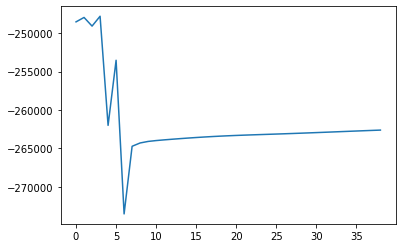

In [420]:
# ------- 2. CAS SUR LES CLASSES 2 ET 3, PASSAGE A UN CODAGE EN {0, 1} POUR Y -------

cl1 = 2
cl2 = 3

# Données d'apprentissage
X_23 = X[(Y==cl1)|(Y==cl2),:]
Y_23 = np.where(Y[(Y==cl1)|(Y==cl2)] == cl1, 1., 0.)

# Données de test
Xt_23 = Xt[(Yt==cl1)|(Yt==cl2),:]
Yt_23 = np.where(Yt[(Yt==cl1)|(Yt==cl2)] == cl1, 1., 0.)

print("Taille des données :",X_23.shape,Y_23.shape)


# --- Apprentissage du paramètre w* à partir des données d'apprentissage X_23 et Y_23

w, L = rl_gradient_batch_L(X_23, Y_23, epsilon = 1e-3, niter_max=1000)
#print(L)

plt.figure()
plt.plot(L)

In [425]:
# ------- Affichage de L la liste des vraisemblances -------
print('L = ', L)
Y23_app, taux_bc_app = taux_BC(X_23, Y_23, w)
Y23_test, taux_bc_test = taux_BC(Xt_23, Yt_23, w)

print('\n\nTaux de bonne classification: ')
print('\tApp:', taux_bc_app)
print('\tApp:', taux_bc_test)

L =  [-248525.22893211 -247951.13792781 -249077.12414742 -247794.80374494
 -261997.27390799 -253523.93919331 -273522.41440506 -264719.01795189
 -264288.10434278 -264088.62797178 -263975.475143   -263885.10093133
 -263801.90265587 -263723.25209262 -263648.80001388 -263578.62412
 -263513.38359626 -263453.78861866 -263400.06020493 -263351.86966531
 -263308.49069398 -263268.9654438  -263232.23105696 -263197.20359965
 -263162.84585096 -263128.25545203 -263092.7730651  -263056.05041536
 -263018.02414695 -262978.82203301 -262938.66892472 -262897.8261036
 -262856.55983859 -262815.12613186 -262773.7633051  -262732.68832013
 -262692.09450392 -262652.14917749 -262612.99050539]


Taux de bonne classification: 
	App: 0.9820014398848093
	App: 0.9505494505494505


## Exercice 5: Analyse qualitative des solutions

Quels sont les pixels qui jouent un role dans la décision?

1. Pour une classe de données, je peux déjà afficher l'ampleur des poids $\mathbf w$ associés à chaque classe. Cela indique si les pixels sont pondérés positivement ou négativement.
1. Pour une image donnée, je sais que la décision est de la forme:
$$p(y_i=1 | \mathbf x_i) = \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}$$
Ainsi, la décision est formée d'une addition de $x_{ij}\cdot w_j$: les plus fortes composante en valeur absolue sont celles qui participent le plus à la décision. <BR>
Cette approche est particulièrement intéressante pour analyser les erreurs de classification.
Afficher l'image d'un chiffre mal classé et une carte de chaleur indiquant quelles parties de l'image influencent le plus la décision: pour la classe prédite d'une part et pour la classe réelle d'autre part.

<Figure size 432x288 with 0 Axes>

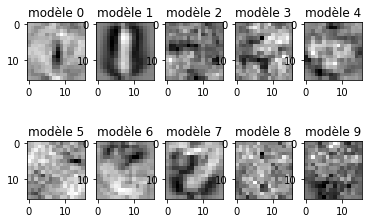

In [426]:
# affichage des poids des paramètres des 10 classes (PAS DE CODE A AJOUTER)
# prérequis: que les w soit en colonnes dans la matrice W
plt.figure()
plt.subplots(2, 5)
for i in range(10):
    plt.subplot(2, 5,i+1)
    plt.imshow(W[:,i].reshape(16,16), cmap="gray")
    plt.title("modèle "+str(i))

3


<Figure size 432x288 with 0 Axes>

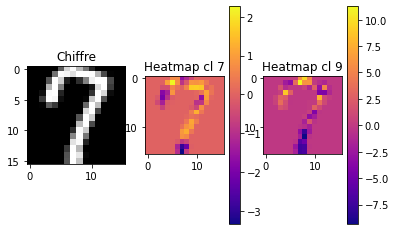

In [427]:
# trouver un échantillon mal classé (PAS DE CODE A AJOUTER):

index = np.where(Y != Y_pred)[0][0] # parmi les points d'apprentissage
print(index)

plt.figure()
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.imshow(X[index].reshape(16,16),cmap="gray")
plt.title("Chiffre")
plt.subplot(1,3,2)
plt.imshow((X[index]*W[:,int(Y[index])]).reshape(16,16),cmap="plasma")
plt.colorbar()
plt.title("Heatmap cl "+str(int(Y[index])))
plt.subplot(1,3,3)
plt.imshow((X[index]*W[:,int(Y_pred[index])]).reshape(16,16),cmap="plasma")
plt.title("Heatmap cl "+str(int(Y_pred[index])))
plt.colorbar()
plt.savefig("malclasse.png")


### Exercice 5-2: limite de la représentation des chiffres

L'expérience précédente met en lumière un phénomène évident: seuls les pixels non nuls jouent un role dans la classification.
C'est très pénalisant, le fait qu'un pixel soit éteint ne peut influencer la décision que par son inaction... Mais pas forcer le système à aller dans une autre classe.

Ce problème est aisément contournable: il suffit de travailler sur $X-1$ (les valeurs de pixels étant entre $0$ et $2$). Les $-1$ qui apparaissent vont alors jouer un role dans la décision.

1. Ré-utiliser (sans modification) ```rl_multi``` sur $X-1$
1. Calculer les performances en pensant bien à faire l'inférence sur $Xt-1$
1. Afficher les contributions des pixels dans cette nouvelle configuration pour une image mal classée

Note: avec la régression logistique, les classes $Y$ doivent être dans $\mathcal Y=\{0,1\}$... Mais il n'y a pas de contrainte sur les $X$. Ajouter des descripteurs négatifs n'est pas un problème.


In [430]:
# il n'y a pas de méthode à redéfinir...
# juste apprendre un nouveau modèle sur des données modifiées... Et ne pas faire d'erreur en inférence.

# --- ETAPE 1: Réutiliser (sans modification) rl_multi sur X - 1

W = rl_multi(X-1,Y)

Convergence atteinte en 120 itérations.
Convergence atteinte en 57 itérations.
Convergence atteinte en 207 itérations.
Convergence atteinte en 180 itérations.
Convergence atteinte en 117 itérations.
Convergence atteinte en 85 itérations.


In [432]:
# perf:
Y_pred  = np.argmax(1/(1+np.exp(-(X-1)@W)),1)
Yt_pred = np.argmax(1/(1+np.exp(-(Xt-1)@W)),1)
# print(Yt[:20],"\n",Yt_pred[:20])
    
pc_good   = np.where(Y_pred == Y , 1., 0.).mean()
pc_good_t = np.where(Yt_pred==Yt , 1., 0.).mean()

print("App : ",pc_good)
print("Test : ",pc_good_t)

App :  0.9556988067480455
Test :  0.9043348281016442


Sortie attendue:
```
App :  0.9663969277191058
Test :  0.8938714499252616
```
On commence à voir l'intérêt de la régression logistique !!

**Notes:**

Dans la partie précédente, nous avions trouvé des taux de bonne classification supérieures à celles attendues:

_Taux obtenus:_

- App :  0.9499382800713209
- Test :  0.8868958644743398

_Taux attendus:_

- App :  0.8824578247154026
- Test :  0.8166417538614849

Cette fois-ci nous voyons bien que le taux de bonne classification sur nos données de test sont bien meilleures.

3


<Figure size 432x288 with 0 Axes>

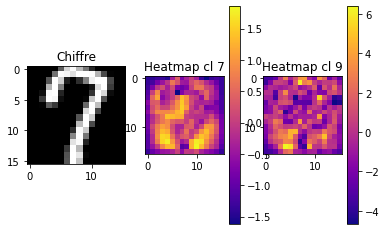

In [435]:
# trouver un échantillon mal classé (PAS DE CODE A AJOUTER):

index = np.where(Y != Y_pred)[0][0] # parmi les points d'apprentissage
print(index)

plt.figure()
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.imshow(X[index].reshape(16,16),cmap="gray")
plt.title("Chiffre")
plt.subplot(1,3,2)
plt.imshow(((X[index]-1)*W[:,int(Y[index])]).reshape(16,16),cmap="plasma")
plt.colorbar()
plt.title("Heatmap cl "+str(int(Y[index])))
plt.subplot(1,3,3)
plt.imshow(((X[index]-1)*W[:,int(Y_pred[index])]).reshape(16,16),cmap="plasma")
plt.title("Heatmap cl "+str(int(Y_pred[index])))
plt.colorbar()

## Exercice 6: Régularisation, performance & interprétation

Dans ce problème en assez grande dimension (256), nous voyons un peu de sur-apprentissage: les performances sont meilleures en apprentissage qu'en test.

On fait souvent l'hypothèse que ce phénomène est lié à un estimateur trop complexe. Afin de simplifier la fonction de coût, on proposer de régulariser le problème d'apprentissage qui devient:

$$\arg\max_\theta  \mathcal L - \lambda \Omega(\theta), \qquad \mbox{avec: } \Omega(\theta) = \left\{\begin{array}{cl}
\sum_j \theta_j^2 & \mbox{ régularisation } L_2 \\
\sum_j |\theta_j| & \mbox{ régularisation } L_1 \\
\end{array}
\right.$$

$\lambda$ doit être choisi soigneusement sous peine d'aboutir à une solution dégénée (ou non modifiée). La régularisation $L_2$ est plus stable est facile à exploiter, la régularisation $L_1$ est plus complexe et moins stable mais elle permet d'annuler complètement les poids attribués à certains pixels. En effet, dans l'implémentation, nous allons traiter la fonction $\Omega$ à part de la vraisemblance:
Toutes les itérations, nous allons mettre à jour:

$$\mathbf w \leftarrow \mathbf w - \lambda \left\{\begin{array}{cl}
\nabla_{\mathbf w,b} \Omega(\mathbf w,b) = 2\mathbf w, 2b  & \mbox{ régularisation } L_2 \\
\nabla_{\mathbf w,b} \Omega(\mathbf w,b) = sign(\mathbf w),sign(b) & \mbox{ régularisation } L_1 \\
\end{array}
\right. $$

En interprétant la formule ci-dessus, on se rend compte que ça ramène systématiquement les poids du modèle vers 0: l'idée est donc bien de simplifier le modèle... Seuls les dimensions vraiment intéressantes seront pondérées.

**Note:** Par défaut, il n'est pas évident d'améliorer les performances avec la régularisation sur ce problème... C'est néanmoins une procédure très efficace sur la plupart des jeux de données.

**Note2:** Les expériences étant un peu chères en temps de calcul, pensez à réduire niter_max pendant le debug

In [442]:
def rl_gradient_batch_reg(X,Y, epsilon = 1e-3, niter_max=1000, lam=1e-5):
    """ Fonction de montée de gradient permettant de trouver le paramètre w optimal,
        ie le w qui minimise la fonction de coût. Retourne le w optimal ainsi que la liste des
        nIterations w calculés
        @param X: float array, ensemble des échantillons
        @param Y: float array, classes associées à chaque échantillon de X
        @param epsilon: float, erreur/bruit/résidu
        @param niter_max: int, nombre d'itérations sur w
        @param lam: float, paramètre lambda
        @return w: float array, w optimal
    """
    N,d = X.shape

    # --- ETAPE 0: Initialisation de w à 0
    w = np.zeros(d, dtype=float)
    
    # --- ETAPE 1: Boucle sur w
    iter = 0
    while iter < niter_max:
        Xw = np.dot(X, w)
        w_new = w + epsilon * np.dot(X.T, Y - 1/(1 + np.exp(-Xw))) # Calcul du gradient
        
        if np.max(np.abs(w_new-w)) < 10e-3:
            print('Convergence atteinte en', iter, 'itérations.')
            break
        else:
            w = w_new - lam * 2 * w_new
            iter += 1
    
    return w

# Soit vous passez des fonctions en arguments, soit il faut redéfinir une nouvelle version de rl_multi
# dans le cadre du TP, on prend la seconde option: plus simple mais plus moche
def rl_multi_reg(X,Y, epsilon = 1e-3, niter_max=1000, lam=1e-5):
    N,d = X.shape
    
    # --- ETAPE 1: Extraction de toutes les classes de Y, initialisation de W
    classes = np.unique(Y)
    W = []
    
    # --- ETAPE 2: Initialiser les poids & lancer un modèle par classe
    # dans la boucle for, vous pouvez utiliser : Y_tmp = np.where(Y == c, 1., 0.)
    
    for c in classes: # Pour chaque classe c
        
        # Données d'apprentissage
        Y_c = np.where(Y == c, 1., 0.)
        
        W.append(rl_gradient_batch_reg(X, Y_c, epsilon, niter_max, lam))
    
    # On redimensionne W pour obtenir l'empilement de W voulu:
    d = W[0].shape[0]
    W_star = W[0].reshape(d,1)
    for i in range(1,len(W)):
        W_star = np.hstack((W_star, W[i].reshape(d,1)))
    
    return W_star

In [440]:
# ------- 2. CAS SUR LES CLASSES 2 ET 3, PASSAGE A UN CODAGE EN {0, 1} POUR Y -------

cl1 = 2
cl2 = 3

# Données d'apprentissage
X_23 = X[(Y==cl1)|(Y==cl2),:]
Y_23 = np.where(Y[(Y==cl1)|(Y==cl2)] == cl1, 1., 0.)

# Données de test
Xt_23 = Xt[(Yt==cl1)|(Yt==cl2),:]
Yt_23 = np.where(Yt[(Yt==cl1)|(Yt==cl2)] == cl1, 1., 0.)

print("Taille des données :",X_23.shape,Y_23.shape)


# --- Apprentissage du paramètre w* à partir des données d'apprentissage X_23 et Y_23

w = rl_gradient_batch_reg(X_23, Y_23, epsilon = 1e-3, niter_max=1000, lam=1e-5)

Y23_app, taux_bc_app = taux_BC(X_23, Y_23, w)
Y23_test, taux_bc_test = taux_BC(Xt_23, Yt_23, w)

print('\n\nTaux de bonne classification: ')
print('\tApp:', taux_bc_app)
print('\tApp:', taux_bc_test)

Taille des données : (1389, 256) (1389,)
Convergence atteinte en 39 itérations.


Taux de bonne classification: 
	App: 0.9820014398848093
	App: 0.9505494505494505


In [444]:
# duree execution = 30 secondes
# n'hésitez pas à mettre un niter_max à 10 durant la phase de debug pour gagner du temps !
W = rl_multi_reg(X,Y)

<ipython-input-442-1914a0acb791>:21: RuntimeWarning: overflow encountered in exp
  w_new = w + epsilon * np.dot(X.T, Y - 1/(1 + np.exp(-Xw))) # Calcul du gradient


Convergence atteinte en 343 itérations.
Convergence atteinte en 94 itérations.
Convergence atteinte en 326 itérations.
Convergence atteinte en 621 itérations.
Convergence atteinte en 119 itérations.
Convergence atteinte en 132 itérations.
Convergence atteinte en 159 itérations.


In [460]:
np.dot(W,W.T)

array([[ 1.09589038,  1.08604774,  1.47070155, ...,  1.03872529,
         0.78178145,  0.19918765],
       [ 1.08604774,  2.21450893,  3.5461807 , ...,  1.08257772,
         0.43244993, -0.10586156],
       [ 1.47070155,  3.5461807 ,  6.99660473, ...,  5.56215567,
         1.87426095,  0.11849351],
       ...,
       [ 1.03872529,  1.08257772,  5.56215567, ..., 17.10139563,
         6.03990145,  1.60685937],
       [ 0.78178145,  0.43244993,  1.87426095, ...,  6.03990145,
         3.6190833 ,  0.96057487],
       [ 0.19918765, -0.10586156,  0.11849351, ...,  1.60685937,
         0.96057487,  0.32150998]])

In [454]:
# Evaluation des performances

lam=1e-5

# perf:
Y_pred  = np.argmax(1/(1+np.exp(-X@W)) - lam * np.sum(np.dot(W,W.T)),1)
Yt_pred = np.argmax(1/(1+np.exp(-Xt@W)) - lam * np.sum(np.dot(W,W.T),1))
# print(Yt[:20],"\n",Yt_pred[:20])

pc_good   = np.where(Y_pred == Y , 1., 0.).mean()
pc_good_t = np.where(Yt_pred==Yt , 1., 0.).mean()

print("App : ",pc_good)
print("Test : ",pc_good_t)

ValueError: operands could not be broadcast together with shapes (2007,10) (256,) 

## Exercice 6: Malédiction de la dimensionnalité

Nous vous proposons ici de modifier les données pour ajouter des colonnes de bruit. Montrer que la performances se réduit lorsque l'on augmente le nombre de dimensions fantomes.

- la fonction d'ajout des données fantomes est fournie
- faites la boucle avec des ajouts de $[0,100,150,200,250]$ colonnes et tracer l'évolution des performances en apprentissage et en test.
    - Attention: il faut donc modifier $X$ et $Xt$ avec le même nombre de colonne fantome
    
**Note:** les expériences sont couteuses, encore une fois, limitez niter_max ou faites les calculs sur un serveur distant (3 minutes en limitant à 300 itérations)... <BR>
Attention, le fait de limiter les itérations est une forme de régularisation (appelée *early stopping*): s'il n'y a pas assez d'itération, on ne voit pas les effets pervers de la dimensionnalité des données!

**Note 2:** Evidemment, c'est dans ce cas de figure -qui correspond à beaucoup d'applications réelles- que la régularisation va aider.

Avec 300 itérations, vous obtenez:
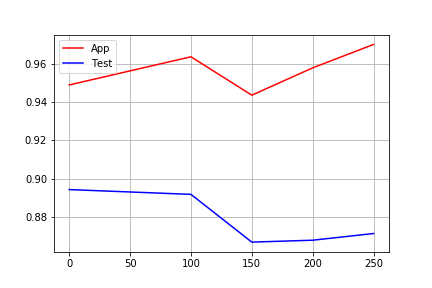

In [ ]:
# On ajoute du bruit (et on enlève 1) 
# ATTENTION : ne pas enlever une seconde fois 1 ensuite !
def ajout_colonne_randn(X,d, sig = 1.):
    return np.hstack((X-1, np.random.randn(len(X),d)*sig))

In [ ]:
dnoise    = np.array([0,100,150,200,250])
perf_app  = np.zeros(len(dnoise))
perf_test = np.zeros(len(dnoise))

for i,d in enumerate(dnoise):
    #TODO
    perf_app[i]   = np.where(Y_pred == Y , 1., 0.).mean()
    perf_test[i]  = np.where(Yt_pred==Yt , 1., 0.).mean()

In [ ]:
plt.figure()
plt.plot(dnoise,perf_app, 'r')
plt.plot(dnoise,perf_test, 'b')
plt.legend(['App','Test'])
plt.grid()
plt.savefig('CurseDim.png')

## Exercice 7: et par rapport aux méthodes discriminantes à base de fonctions de cout?

Tester l'algorithme du perceptron vu en cours, avec l'astuce du un-contre-tous pour le passage au multi-classes.
Attention, pour le perceptron, le codage des deux classes est en $\{-1, 1\}$